# Chunk Activation UMAP (2D/3D)

Loads per-chunk mean activation vectors from `steering_anchors_{model}.json`, loads TA-style chunk categories, and plots UMAP projections color-coded by category.

In [1]:
import os, json, math, random, gc
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Try UMAP; fallback to sklearn if unavailable
try:
    import umap
    HAVE_UMAP = True
except Exception:
    HAVE_UMAP = False
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

# Resolve repo root (same pattern as other notebooks)
repo_root = Path.cwd().resolve().parents[0] if (Path.cwd()).exists() else Path.cwd().resolve()
repo_root

/opt/conda/envs/anchorsteering/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PosixPath('/home/cutterdawes/SteeringThoughtAnchors')

In [2]:
# Config
model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B'
model_tag = model_name.replace('/', '-')
anchors_path = repo_root / 'generated_data' / f'steering_anchors_{model_tag}.json'
categories_path = repo_root / 'generated_data' / f'chunk_categories_{model_tag}.json'
output_dir = repo_root / 'generated_data' / 'figures'
output_dir.mkdir(parents=True, exist_ok=True)
anchors_path, categories_path

(PosixPath('/home/cutterdawes/SteeringThoughtAnchors/generated_data/steering_anchors_deepseek-ai-DeepSeek-R1-Distill-Qwen-1.5B.json'),
 PosixPath('/home/cutterdawes/SteeringThoughtAnchors/generated_data/chunk_categories_deepseek-ai-DeepSeek-R1-Distill-Qwen-1.5B.json'))

In [3]:
# Load data
with open(anchors_path, 'r') as f:
    anchors_payload = json.load(f)
with open(categories_path, 'r') as f:
    cats_payload = json.load(f)
len(anchors_payload.get('examples', [])), len(cats_payload.get('examples', []))

(2, 2)

In [4]:
# TA category colors (replicated)
CATEGORY_COLORS = {
    'Active Computation': '#34A853',
    'Fact Retrieval': '#FBBC05',
    'Final Answer Emission': '#795548',
    'Plan Generation': '#EA4335',
    'Problem Setup': '#4285F4',
    'Result Consolidation': '#00BCD4',
    'Self Checking': '#FF9800',
    'Uncertainty Management': '#9C27B0'
}

def tag_to_display(tag: str) -> str:
    # Convert snake_case to Title Case to match palette keys
    s = (tag or 'unknown').replace('_', ' ').strip()
    return ' '.join([w.capitalize() for w in s.split()])

def pick_color(display_tag: str) -> str:
    return CATEGORY_COLORS.get(display_tag, '#7f7f7f')

In [5]:
# Build dataset: X = vectors, y = display_tag, meta = (example, chunk)
X = []
Y = []
META = []
examples_anchors = anchors_payload.get('examples', [])
examples_cats = cats_payload.get('examples', [])
# Build index mapping for categories by example_index (defensive)
cat_by_idx = {e.get('example_index', i): e for i, e in enumerate(examples_cats)}
for ex_i, ex in enumerate(examples_anchors):
    chunks = ex.get('chunks', [])
    cat_entry = cat_by_idx.get(ex_i, {})
    cat_map = cat_entry.get('categories', {})
    for ch in chunks:
        idx = int(ch.get('chunk_index', 0))
        vec = ch.get('vector', [])
        if not vec:
            continue
        # Label: take first function tag if available
        tags = cat_map.get(str(idx), {}).get('function_tags', ['unknown'])
        primary = tags[0] if tags else 'unknown'
        disp = tag_to_display(primary)
        X.append(vec)
        Y.append(disp)
        META.append((ex_i, idx))
X = np.asarray(X, dtype=np.float32)
len(X), len(Y), len(META)

(46, 46, 46)

/opt/conda/envs/anchorsteering/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


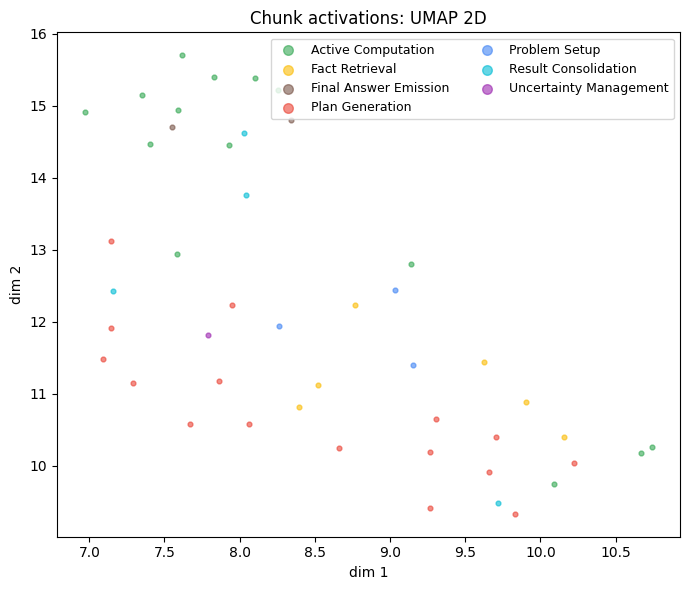

In [6]:
# 2D projection
if HAVE_UMAP:
    reducer2 = umap.UMAP(n_components=2, random_state=42, metric='cosine')
    X2 = reducer2.fit_transform(X)
else:
    # PCA fallback for 2D
    X2 = PCA(n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(7,6))
for cls in sorted(set(Y)):
    mask = np.array([y == cls for y in Y])
    color = pick_color(cls)
    plt.scatter(X2[mask,0], X2[mask,1], s=12, alpha=0.6, c=color, label=cls)
plt.legend(markerscale=2, fontsize=9, ncol=2)
plt.title('Chunk activations: UMAP 2D' if HAVE_UMAP else 'Chunk activations: PCA 2D')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.tight_layout()
plt.show()

/opt/conda/envs/anchorsteering/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


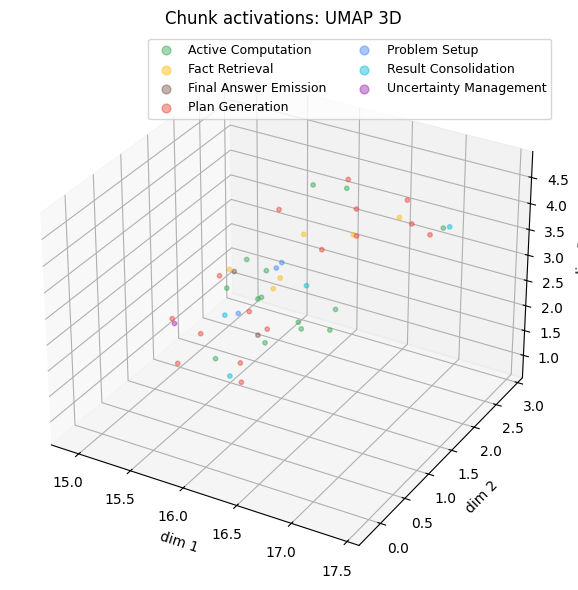

In [7]:
# 3D projection
from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection
if HAVE_UMAP:
    reducer3 = umap.UMAP(n_components=3, random_state=42, metric='cosine')
    X3 = reducer3.fit_transform(X)
else:
    # t-SNE fallback for 3D (heavier); if it fails, fallback to PCA
    try:
        X3 = TSNE(n_components=3, random_state=42, init='pca', learning_rate='auto').fit_transform(X)
    except Exception:
        from sklearn.decomposition import PCA
        X3 = PCA(n_components=3, random_state=42).fit_transform(X)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for cls in sorted(set(Y)):
    mask = np.array([y == cls for y in Y])
    color = pick_color(cls)
    ax.scatter(X3[mask,0], X3[mask,1], X3[mask,2], s=10, alpha=0.45, c=color, label=cls)
ax.set_title('Chunk activations: UMAP 3D' if HAVE_UMAP else 'Chunk activations: TSNE/PCA 3D')
ax.set_xlabel('dim 1')
ax.set_ylabel('dim 2')
ax.set_zlabel('dim 3')
plt.legend(markerscale=2, fontsize=9, ncol=2)
plt.tight_layout()
plt.show()

In [8]:
# Print each chunk alongside its category (for manual inspection)
for (ex_i, ch_i), cat in zip(META, Y):
    ex = examples_anchors[ex_i]
    chunks = ex.get('chunks', [])
    chunk = next((c for c in chunks if int(c.get('chunk_index', -1)) == ch_i), None)
    text = chunk.get('text', '').strip() if chunk else ''
    print(f'Example {ex_i} Chunk {ch_i} [{cat}]:\n{text}\n{"-"*40}\n')

Example 0 Chunk 0 [Problem Setup]:
Okay, so I have this problem to solve: evaluate the product of four cube roots multiplied together.
----------------------------------------

Example 0 Chunk 1 [Problem Setup]:
It's written as √[3]{12} × √[3]{20} × √[3]{15} × √[3]{60}.
----------------------------------------

Example 0 Chunk 2 [Uncertainty Management]:
Hmm, cube roots can sometimes be tricky, but I remember that when you multiply cube roots, you can combine them under a single cube root.
----------------------------------------

Example 0 Chunk 3 [Plan Generation]:
Let me try to recall the properties of radicals.
----------------------------------------

Example 0 Chunk 4 [Fact Retrieval]:
I think the rule is that √[n]{a} × √[n]{b} = √[n]{a × b}.
----------------------------------------

Example 0 Chunk 5 [Plan Generation]:
So, in this case, since all of them are cube roots, I can multiply all the numbers inside the roots together and then take the cube root of the product.
---------